In [1]:
import glob
import os
import cv2
import numpy as np
from keras.models import load_model
from skimage import color

from dataset.utils.inception_utils import inception_resnet_v2_predict
from dataset.utils.resize import resize_pad_frame
from dataset.utils.shared import frames_per_video, default_nn_input_width, default_nn_input_height, resnet_input_height, resnet_input_width
from model import FusionLayer
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

sns.set(rc={'figure.figsize':(20,8)})

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_video(file):
    video = cv2.VideoCapture(file)
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    frames = np.asarray(frames)
    return frames


def get_lab_layer(frames):
    rgb2lab_frames = []
    gray2lab_frames = []

    for frame in frames:
        resized_frame = resize_pad_frame(frame, (default_nn_input_height, default_nn_input_width), equal_padding=True)

        rgb2lab_frame = color.rgb2lab(resized_frame)
        rgb2lab_frames.append(rgb2lab_frame)
        
        rgb2gray_frame = color.rgb2gray(resized_frame)
        # I CHANGED
        cv2.imshow('grey', rgb2gray_frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        # I CHANGED
        
        gray2rgb_frame = color.gray2rgb(rgb2gray_frame)
        lab_frame = color.rgb2lab(gray2rgb_frame)
        gray2lab_frames.append(lab_frame)

    return np.asarray(rgb2lab_frames), np.asarray(gray2lab_frames)

def preprocess_frames(gray2lab_frames):
    processed = np.empty(gray2lab_frames.shape)
    
    processed[:, :, :, 0] = np.divide(gray2lab_frames[:, :, :, 0], 50) - 1  # data loss
    processed[:, :, :, 1] = np.divide(gray2lab_frames[:, :, :, 1], 128)
    processed[:, :, :, 2] = np.divide(gray2lab_frames[:, :, :, 2], 128)
    
    processed_l_layer = processed[:, :, :, np.newaxis, 0]
    
    return processed_l_layer


def get_resnet_records(frames):
    resnet_input = []
    for frame in frames:
        resized_frame = resize_pad_frame(frame, (resnet_input_height, resnet_input_width))
        gray_scale_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)
        gray_scale_frame_colored = cv2.cvtColor(gray_scale_frame, cv2.COLOR_GRAY2RGB)
        resnet_input.append(gray_scale_frame_colored)
    resnet_input = np.asarray(resnet_input)

    predictions = inception_resnet_v2_predict(resnet_input)
    return predictions


def getInputRange(frames_count, time_steps, current_frame):
    '''
    Deciding the moving window
    :param frames_count:
    :param time_steps:
    :param current_frame:
    :return:
    '''
    # this function should change according to our selection of
    frame_selection = []
    last_selection = current_frame
    for i in range(current_frame, current_frame + time_steps):
        if (i >= frames_count):
            frame_selection.append(last_selection)
        else:
            frame_selection.append(i)
            last_selection = i

    return frame_selection


def get_nn_input(l_layer, resnet_out):
    frames_count = l_layer.shape[0]
    time_steps = frames_per_video
    X = []
    Y = []

    for i in range(frames_count):
        frame_index_selection = getInputRange(frames_count, time_steps, i)
        frame_selection = []
        resnet_selection = []
        for j in frame_index_selection:
            frame_selection.append(l_layer[j])
            resnet_selection.append(resnet_out[j])
        X.append(frame_selection)
        Y.append(resnet_selection)

    X = np.asarray(X)
    Y = np.asarray(Y)
    return [X, Y]


def post_process_predictions(original_l_layers, predicted_AB_layers):
    total_frames = original_l_layers.shape[0]
    predicted_frames = []
    for i in range(total_frames):
        l_layer = original_l_layers[i]
        a_layer = np.multiply(predicted_AB_layers[i, 0, :, :, 0], 128)
        b_layer = np.multiply(predicted_AB_layers[i, 0, :, :, 1], 128)
        frame = np.empty((240, 320, 3))
        frame[:, :, 0] = l_layer
        frame[:, :, 1] = a_layer
        frame[:, :, 2] = b_layer
        #frame = color.lab2rgb(frame)
        predicted_frames.append(frame)
    return np.asarray(predicted_frames)


def save_output_video(frames, output_file):
    count = 0
    for frame in frames:
        final_out = color.lab2rgb(frame)
        #final_out = np.asarray(final_out).astype(int)
        #plt.imshow(final_out)
        cv2.imshow('image', final_out)
        cv2.imwrite('/home/chamath/'+"img"+str(count)+".jpg", frame)
        count+=1
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # write to output_file

In [3]:
    # read input video
frames = get_video('/home/chamath/flowchroma_example/sampled/video_00001.avi')
#frames = get_video('/home/chamath/video_00034.avi')


In [5]:
    # get L layer
(rgb2lab_frames, gray2lab_frames) = get_lab_layer(frames)
processed_l_layer = preprocess_frames(gray2lab_frames)
print(processed_l_layer.shape)
print("Completed calculating L layer")


(3, 240, 320, 1)
Completed calculating L layer


(3, 240, 320, 3)
100.0


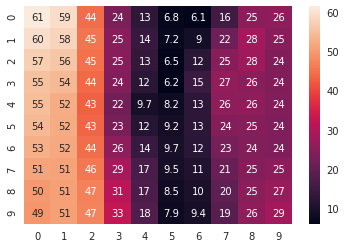

In [6]:
print(rgb2lab_frames.shape)
print(np.amax(rgb2lab_frames[0,:,:,0]))
sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True )


(3, 240, 320, 3)
100.0


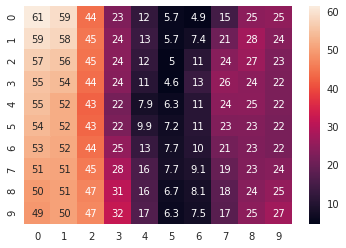

In [7]:
print(gray2lab_frames.shape)
print(np.amax(gray2lab_frames[0,:,:,0]))
sns.heatmap(gray2lab_frames[0,80:90,80:90,0],annot=True )


(3, 240, 320, 1)
1.0


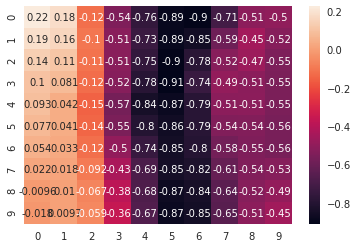

In [8]:
print(processed_l_layer.shape)
print(np.amax(processed_l_layer[0,:,:,0]))
sns.heatmap(processed_l_layer[0,80:90,80:90,0],annot=True )


In [9]:
# get resnet embeddings
predictions = get_resnet_records(frames)
print("Completed calculating resnet records ")

Completed calculating resnet records 


In [10]:
# run flowchroma model
ckpts = glob.glob("checkpoints/*.hdf5")
latest_ckpt = max(ckpts, key=os.path.getctime)
print("loading from checkpoint:", latest_ckpt)
model = load_model(latest_ckpt, custom_objects={'FusionLayer': FusionLayer})
X = get_nn_input(processed_l_layer, predictions)
print(X[0].shape)
predictions = model.predict(X)

print("Flowchroma model predictions calculated")

loading from checkpoint: checkpoints/flowchroma-epoch-00360-lr-0.0001-train_acc-0.7948-val_acc-0.7731.hdf5
(3, 3, 240, 320, 1)
Flowchroma model predictions calculated


In [11]:
frame_predictions = post_process_predictions(gray2lab_frames[:,:,:,0], predictions)


In [12]:
print(frame_predictions.shape)
print(rgb2lab_frames.shape)

(3, 240, 320, 3)
(3, 240, 320, 3)


# L Layer Comparison

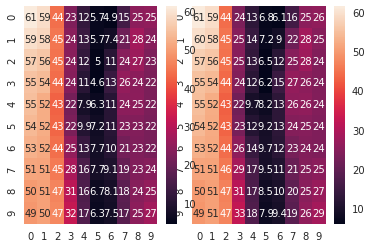

In [13]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)

sns.heatmap(frame_predictions[0,80:90,80:90,0],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,0],annot=True, ax=ax2 )


# A Layer Comparison

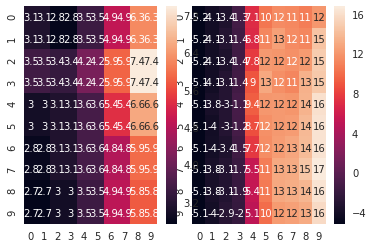

In [14]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,1],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,1],annot=True, ax=ax2 )

# B Layer comparison

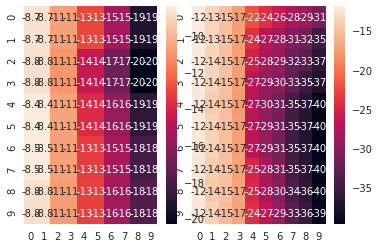

In [15]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=0.01)
sns.heatmap(frame_predictions[0,80:90,80:90,2],annot=True, ax=ax )
sns.heatmap(rgb2lab_frames[0,80:90,80:90,2],annot=True, ax=ax2 )

In [16]:
# write output video file
# save_output_video(rgb2lab_frames, '')


In [17]:
save_output_video(frame_predictions, '')
